<a href="https://colab.research.google.com/github/ma7moudjadallah/Scrape_Classifying_Issues-/blob/main/Final%20Coding%20Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from transformers import pipeline

# Fetch issues from GitHub API
def fetch_issues(repo='rails/rails', state='all', per_page=100, max_pages=5):
    issues = []
    url = f"https://api.github.com/repos/{repo}/issues"
    params = {"state": state, "per_page": per_page}
    headers = {"Accept": "application/vnd.github.v3+json"}

    for page in range(1, max_pages + 1):
        response = requests.get(url, params={**params, "page": page}, headers=headers)
        if response.status_code == 200:
            issues.extend(response.json())
        else:
            print(f"Error fetching issues: {response.status_code}")
            break
    return issues

# Parse fetched issues
def parse_issues(issues):
    parsed_issues = [
        {
            "number": issue["number"],
            "title": issue["title"],
            "created_at": issue["created_at"],
            "comments": issue["comments"],
            "labels": [label["name"] for label in issue.get("labels", [])],
            "reporter": issue["user"]["login"] if "user" in issue else "Unknown",
        }
        for issue in issues
    ]
    return parsed_issues

# Perform exploratory data analysis (EDA)
def perform_eda(df):
    print(f"Total issues scraped: {len(df)}")

    # Visualize top labels
    all_labels = [label for labels in df['labels'] for label in labels]
    if all_labels:
        label_counts = pd.Series(all_labels).value_counts()
        print("Top 5 Labels:")
        print(label_counts.head(5))
        label_counts.head(10).plot(kind='bar', figsize=(10, 6))
        plt.title('Top 10 Labels')
        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.show()

    # Visualize distribution of comments
    if 'comments' in df.columns:
        df['comments'].plot(kind='hist', bins=20, figsize=(10, 6))
        plt.title('Distribution of Comments on Issues')
        plt.xlabel('Number of Comments')
        plt.ylabel('Frequency')
        plt.show()

    # Visualize issue creation over time
    issue_over_time = df.resample('M').size()
    issue_over_time.plot()
    plt.title('Number of Issues Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Issues')
    plt.show()

    # Periods with the most issues
    print("Periods with the most issues:")
    print(issue_over_time.sort_values(ascending=False).head())

    # Visualize monthly issue creation
    monthly_counts = df.index.month.value_counts()
    monthly_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Monthly Issue Creation')
    plt.xlabel('Month')
    plt.ylabel('Number of Issues')
    plt.show()

    # Identify top reporters
    if 'reporter' in df.columns:
        top_reporters = df['reporter'].value_counts().head(5)
        print("Top Reporters:")
        print(top_reporters)

    # Most popular category (label)
    if all_labels:
        label_counts = Counter(all_labels)
        most_popular_label = label_counts.most_common(1)
        print("Most Popular Label:")
        print(most_popular_label)




In [2]:
# Classify issues using zero-shot classification
def classify_issues(issues, candidate_labels):
    classifier = pipeline("zero-shot-classification", model="cross-encoder/nli-distilroberta-base")
    descriptions = [issue['title'] for issue in issues]
    classifications = classifier(descriptions, candidate_labels=candidate_labels)

    summarized_classifications = [
        {
            'title': issues[i]['title'],
            'label': classification['labels'][0],
            'score': classification['scores'][0]
        }
        for i, classification in enumerate(classifications)
    ]
    return summarized_classifications

Total issues scraped: 500
Top 5 Labels:
activerecord     147
docs              98
railties          93
actionpack        39
activesupport     34
Name: count, dtype: int64


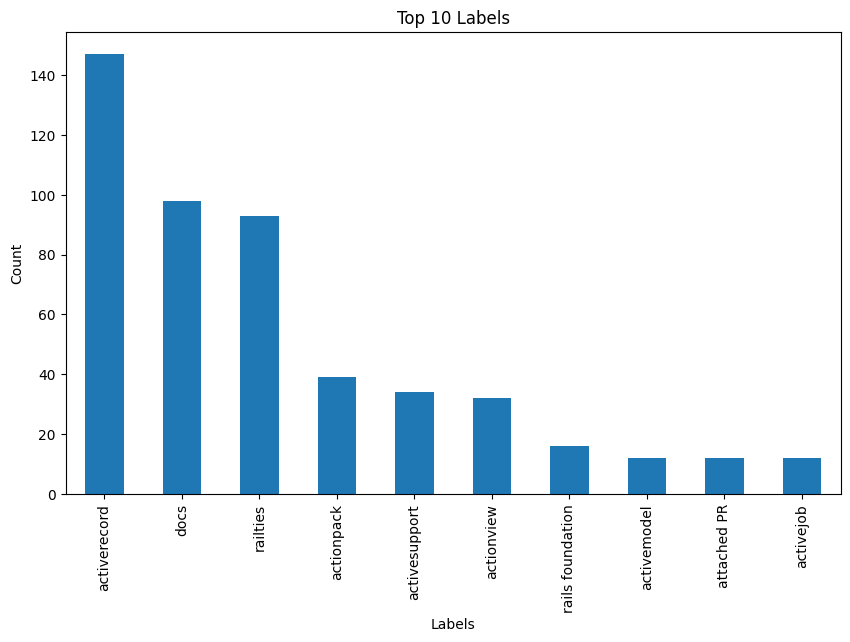

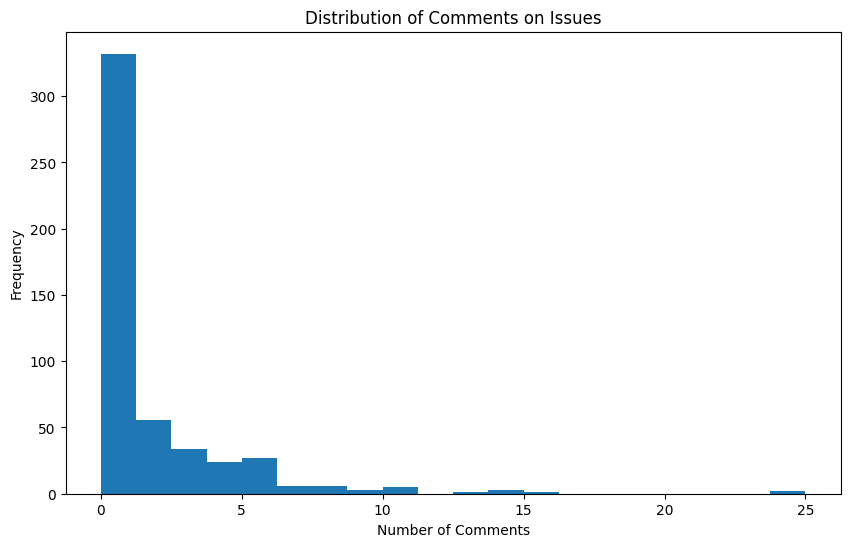

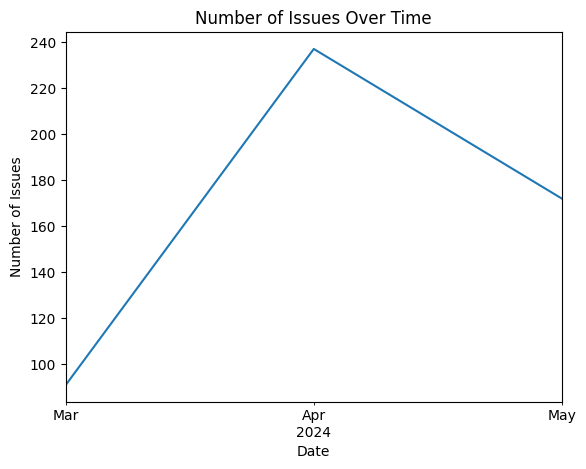

Periods with the most issues:
created_at
2024-04-30 00:00:00+00:00    237
2024-05-31 00:00:00+00:00    172
2024-03-31 00:00:00+00:00     91
dtype: int64


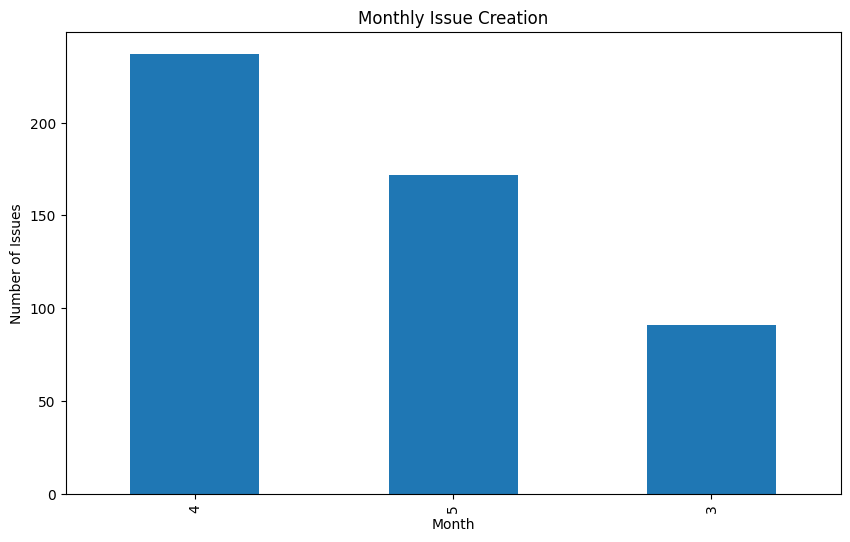

Top Reporters:
reporter
casperisfine      28
fatkodima         24
andrewn617        20
Earlopain         13
akhilgkrishnan    12
Name: count, dtype: int64
Most Popular Label:
[('activerecord', 147)]
Classified Issues:
Title: [ci skip] Align documentation with conventional practice
Predicted Label: docs
Confidence Score: 0.15
--------------------------------------------------
Title: /Users/amol/.rvm/gems/ruby-2.5.1/gems/activerecord-5.0.2/lib/active_record/connection_adapters/mysql2_adapter.rb:68: [BUG] Segmentation fault at 0x94000f78d65f0300 ruby 2.5.1p57 (2018-03-29 revision 63029) [x86_64-darwin23]
Predicted Label: activerecord
Confidence Score: 0.26
--------------------------------------------------
Title: Rails 7.1 Transactional tests, threaded code and schema caching can cause deadlocks
Predicted Label: railties
Confidence Score: 0.22
--------------------------------------------------
Title: Fixed a typo in active_record_postgresql.md
Predicted Label: PostgreSQL
Confidence Score:

In [5]:

# Main function
def main():
    issues = fetch_issues()
    parsed_issues = parse_issues(issues)
    df = pd.DataFrame(parsed_issues)
    df['created_at'] = pd.to_datetime(df['created_at'])
    df.set_index('created_at', inplace=True)
    perform_eda(df)

    candidate_labels = list(set([label for labels in df['labels'] for label in labels]))
    classified_issues = classify_issues(parsed_issues, candidate_labels)

    print("Classified Issues:")
    for classified_issue in classified_issues[:10]:  # Display only first 10 for brevity
        print(f"Title: {classified_issue['title']}")
        print(f"Predicted Label: {classified_issue['label']}")
        print(f"Confidence Score: {classified_issue['score']:.2f}")
        print("-" * 50)

if __name__ == "__main__":
    main()
